# Residual Autoencoders for Pretraining EEG Signal Classifiers

---

__By Elliott Forney - 2020__

In [1]:
import copy
from glob import glob
import pickle
import munch

import math
import torch as th
import numpy as np
import scipy as sp
import scipy.signal as _

import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
plt.rcParams['figure.figsize'] = [14, 8.5]

## Autoencoder Data Preparation

In [2]:
filenames = sorted(glob('data/rest/*.pkl'))
filenames

['data/rest/s08-3minutes.pkl',
 'data/rest/s08-letter-b.pkl',
 'data/rest/s08-letter-d.pkl',
 'data/rest/s08-letter-p.pkl',
 'data/rest/s08-mentaltasks.pkl',
 'data/rest/s10-3minutes.pkl',
 'data/rest/s10-letter-b.pkl',
 'data/rest/s10-letter-d.pkl',
 'data/rest/s10-letter-p.pkl',
 'data/rest/s10-mentaltasks.pkl',
 'data/rest/s11-3minutes.pkl',
 'data/rest/s11-letter-b.pkl',
 'data/rest/s11-letter-d.pkl',
 'data/rest/s11-letter-p.pkl',
 'data/rest/s11-mentaltasks.pkl',
 'data/rest/s12-3minutes.pkl',
 'data/rest/s12-letter-b.pkl',
 'data/rest/s12-letter-d.pkl',
 'data/rest/s12-letter-p.pkl',
 'data/rest/s12-mentaltasks.pkl',
 'data/rest/s13-3minutes.pkl',
 'data/rest/s13-letter-b.pkl',
 'data/rest/s13-letter-d.pkl',
 'data/rest/s13-letter-p.pkl',
 'data/rest/s13-mentaltasks.pkl',
 'data/rest/s15-3minutes.pkl',
 'data/rest/s15-letter-b.pkl',
 'data/rest/s15-letter-d.pkl',
 'data/rest/s15-letter-p.pkl',
 'data/rest/s15-mentaltasks.pkl',
 'data/rest/s16-3minutes.pkl',
 'data/rest/s16-lette

In [3]:
subjects = (8, 10, 11, 12, 13, 15, 16, 20, 21, 22, 23, 24, 25, 26, 27, 28)
len(subjects)

16

In [4]:
chan_names_biosemi_32 = (
    'Fp1', 'AF3', 'F7',  'F3',  'FC1', 'FC5', 'T7',  'C3',
    'CP1', 'CP5', 'P7',  'P3',  'Pz',  'PO3', 'O1',  'Oz',
    'O2',  'PO4', 'P4',  'P8',  'CP6', 'CP2', 'C4',  'T8',
    'FC6', 'FC2', 'F4',  'F8',  'AF4', 'Fp2', 'Fz',  'Cz',
    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8',
)

chan_names_biosemi_64 = (
    'Fp1', 'AF7', 'AF3', 'F1',  'F3',  'F5',  'F7',  'FT7',
    'FC5', 'FC3', 'FC1', 'C1',  'C3',  'C5',  'T7',  'TP7',
    'CP5', 'CP3', 'CP1', 'P1',  'P3',  'P5',  'P7',  'P9',
    'PO7', 'PO3', 'O1',  'Iz',  'Oz',  'POz', 'Pz',  'CPz',
    'Fpz', 'Fp2', 'AF8', 'AF4', 'AFz', 'Fz',  'F2',  'F4',
    'F6',  'F8',  'FT8', 'FC6', 'FC4', 'FC2', 'FCz', 'Cz',
    'C2',  'C4',  'C6',  'T8',  'TP8', 'CP6', 'CP4', 'CP2',
    'P2',  'P4',  'P6',  'P8',  'P10', 'PO8', 'PO4', 'O2',
    'EXG1','EXG2','EXG3','EXG4','EXG5','EXG6','EXG7','EXG8',
)

In [5]:
select_chan_names = (
    'C3', 'C4', 'Cz', 'F3', 'F4', 'F7', 'F8', 'Fp1', 'Fp2',                 
    'Fz', 'O1', 'O2', 'P3', 'P4', 'P7', 'P8', 'Pz', 'T7', 'T8',
)

#select_chan_names = (
#    'Fp1', 'AF3', 'F7',  'F3',  'FC1', 'FC5', 'T7',  'C3',
#    'CP1', 'CP5', 'P7',  'P3',  'Pz',  'PO3', 'O1',  'Oz',
#    'O2',  'PO4', 'P4',  'P8',  'CP6', 'CP2', 'C4',  'T8',
#    'FC6', 'FC2', 'F4',  'F8',  'AF4', 'Fp2', 'Fz',  'Cz',
#)

len(select_chan_names)

19

In [6]:
class EEGDataset(th.utils.data.Dataset):
    def __init__(self, data, samp_rate, chan_names):
        super().__init__()
        
        self.data = data
        self.samp_rate = samp_rate
        self.chan_names = chan_names
        
    @staticmethod
    def _make_bandpass(samp_rate, low_freq, high_freq, order=6):
        '''Bidirectional Butterworth linear IIR bandpass filter.
        '''
        # compute the filter coefficients
        #numer_coef, denom_coef = sp.signal.iirfilter(
        #    order, (low_freq, high_freq), ftype='butter', btype='bandpass', fs=samp_rate)
        sos = sp.signal.iirfilter(
            order, (low_freq, high_freq), ftype='butter', btype='bandpass', fs=samp_rate, output='sos')
    
        def bandpass(data):
            # apply the filter in both directions
            return th.as_tensor(
                #sp.signal.filtfilt(numer_coef, denom_coef, data.numpy(), axis=0, padtype='even').copy(),
                sp.signal.sosfiltfilt(sos, data.numpy(), axis=0, padtype='even').copy(),
                dtype=th.float32)
    
        return bandpass
    
    
    @staticmethod
    def _make_notch(samp_rate, freq, quality=30.0):
        '''Bidirectional Butterworth linear IIR notch filter.
        '''
        numer_coef, denom_coef = sp.signal.iirnotch(freq, quality, fs=samp_rate)
        
        def notch(data):
            return th.as_tensor(
                sp.signal.filtfilt(numer_coef, denom_coef, data.numpy(), axis=0, padtype='even').copy(),
                dtype=th.float32)
        
        return notch
        
    @staticmethod
    def _prep(data, full_chan_names, select_chan_names,
              bandpass_filter, notch_filter, clamp, downsample_factor):       
        ref_chan_idxs = full_chan_names.index('EXG5'), full_chan_names.index('EXG6')
        #eog_vchan_idxs = full_chan_names.index('EXG1'), full_chan_names.index('EXG2')
        #eog_hchan_idxs = full_chan_names.index('EXG3'), full_chan_names.index('EXG4')
        select_chan_idxs = tuple(full_chan_names.index(chan_name) for chan_name in select_chan_names)

        data -= data.mean(0)
        reference = data[:, ref_chan_idxs].mean(1)[:, None]
        data -= reference
        data -= data.mean(0)

        data = notch_filter(data)
        data = bandpass_filter(data)[::downsample_factor]

        #veog = data[:, eog_vchan_idxs[1]] - data[:, eog_vchan_idxs[0]]                                      
        #heog = data[:, eog_hchan_idxs[1]] - data[:, eog_hchan_idxs[0]]                                      
        #eog = th.stack((veog, heog, th.ones(veog.shape[0]))).T

        data = data[:, select_chan_idxs]
            
        #eog_weights = th.pinverse(eog) @ data
        #data -= eog @ eog_weights
            
        data = data.clamp(-clamp, clamp)

        return data
    
    def plot_trace(self, n, scale_factor=1.0):
        segment = self[n] if isinstance(n, int) else n        
        segment = segment.T
        
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)
    
        nsec = segment.shape[0] / self.samp_rate
    
        nchan = len(self.chan_names)
    
        scale = th.max(th.abs(segment))                                                                                                                                                                   
        sep = -th.arange(segment.shape[1]) * scale_factor * scale
        segment = segment + sep
        
        time = th.linspace(0, nsec, segment.shape[0])
    
        ax.plot(time, segment)
        ax.set_xlabel(r'Time ($s$)')
        ax.set_ylabel(r'Signal ($\mu V$) Across Channels')
        ax.set_yticks(sep)
        ax.set_yticklabels([c for i, c in enumerate(self.chan_names)])
        ax.autoscale(tight=True)
        
    def plot_psd(self, n):
        segment = self[n] if isinstance(n, int) else n
        
        freqs, powers = sp.signal.welch(segment, self.samp_rate)

        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1)

        ax.plot(freqs, powers.T);
        ax.set_xlabel('Frequency (Hz)');
        ax.set_ylabel(r'Power Density ($\mu V^2/Hz$');
        ax.set_yscale('log');

        ax.grid();
        ax.legend(self.chan_names, ncol=2);
        ax.autoscale(tight=True)
    
    def __getitem__(self, idx):
        return self.data[idx]
    
    def __len__(self):
        return self.data.shape[0]
    
    @property
    def nseg(self):
        return self.data.shape[0]
    
    @property
    def nchan(self):
        return self.data.shape[1]
    
    @property
    def nstep(self):
        return self.data.shape[2]

In [7]:
class AutoencoderDataset(EEGDataset):
    def __init__(self, subjects, nsec=2.0, overlap=0.5, samp_rate=1024.0,
                 low_freq=0.5, high_freq=100.0, downsample_factor=4, clamp=60.0,
                 full_chan_names=chan_names_biosemi_32, select_chan_names=select_chan_names,
                 means=None, stdevs=None):
        orig_samp_rate = samp_rate
        new_samp_rate = samp_rate / downsample_factor
        del samp_rate
        
        data_mats = []
        
        bandpass_filter = self._make_bandpass(orig_samp_rate, low_freq, high_freq)
        notch_filter = self._make_notch(orig_samp_rate, 60.0)
        
        for subject in subjects:
            filenames = sorted(glob(f'data/rest/s{subject:02}-*.pkl'))

            for filename in filenames:
                with open(filename, mode='rb') as fh:
                    raw_data = th.as_tensor(pickle.load(fh), dtype=th.float32)
                    
                data = self._prep(
                    data=raw_data,
                    full_chan_names=full_chan_names,
                    select_chan_names=select_chan_names,
                    bandpass_filter=bandpass_filter,
                    notch_filter=notch_filter,
                    clamp=clamp,
                    downsample_factor=downsample_factor)
                
                width = int(new_samp_rate * nsec)
                stride = int(width * (1.0 - overlap))
                for start in range(0, data.shape[0], stride):
                    end = start + width
                    if end < data.shape[0]:
                        data_mats.append(data[start:end].clone())
                        
        data = th.stack(data_mats)
        
        assert len(select_chan_names) == data.shape[-1]
        nchan = data.shape[-1]

        self.means = data.reshape((-1, nchan)).mean(0) if means is None else means        
        assert self.means.shape == (nchan,)
        data -= self.means

        self.stdevs = data.reshape((-1, nchan)).std(0) if stdevs is None else stdevs
        assert self.stdevs.shape == (nchan,)
        data /= self.stdevs
        
        # we switch to shape (nseg, nchan, nobs) here since pytorch
        # convolution operators expect channel first
        data = data.permute(0, 2, 1)

        super().__init__(data, new_samp_rate, select_chan_names)

In [8]:
train_data = AutoencoderDataset(subjects=subjects[1:-1])
valid_data = AutoencoderDataset(
    subjects=(subjects[0], subjects[-1]),
    means=train_data.means,
    stdevs=train_data.stdevs)

len(train_data), len(valid_data)

(10279, 1477)

In [9]:
train_data.means.shape, train_data.stdevs.shape

(torch.Size([19]), torch.Size([19]))

In [10]:
train_data[0].shape, train_data[0].reshape((-1, 19)).mean(0)

(torch.Size([19, 512]),
 tensor([0.0308, 0.0263, 0.0235, 0.0166, 0.0162, 0.0230, 0.0058, 0.0125, 0.0422,
         0.0388, 0.0277, 0.0361, 0.0347, 0.0263, 0.0306, 0.0310, 0.0329, 0.0392,
         0.0337]))

In [11]:
train_data[0].shape, train_data[0].reshape((-1, 19)).std(0)

(torch.Size([19, 512]),
 tensor([0.5583, 0.5835, 0.5545, 0.5387, 0.5678, 0.5852, 0.6017, 0.6083, 0.5898,
         0.5633, 0.5606, 0.5729, 0.5773, 0.5732, 0.5759, 0.5855, 0.5739, 0.5619,
         0.5551]))

In [12]:
1024 / 4

256.0

In [13]:
train_data.samp_rate

256.0

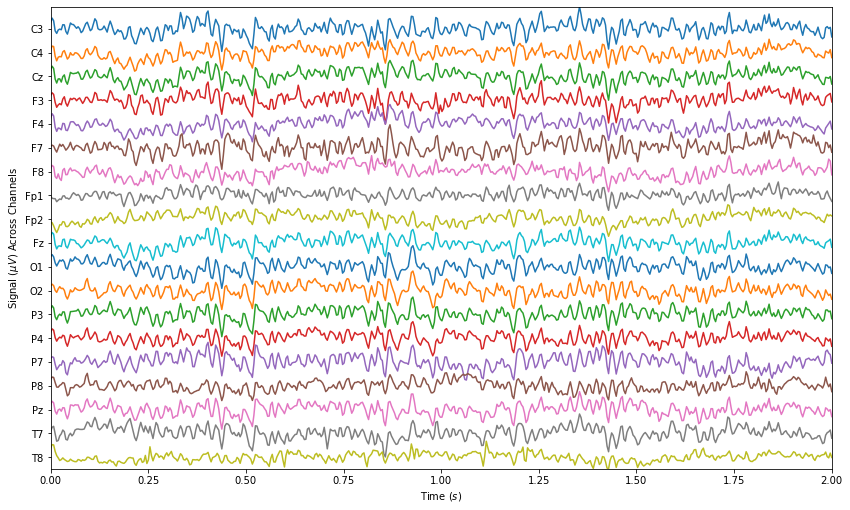

In [14]:
train_data.plot_trace(0)

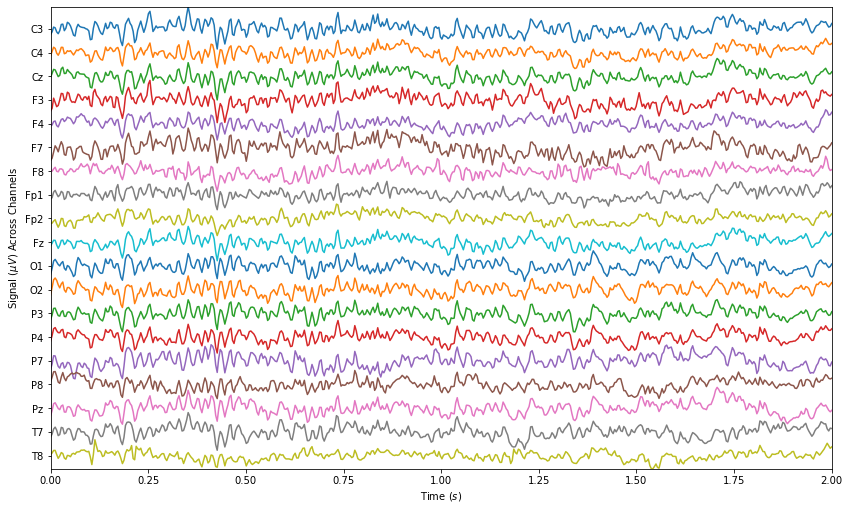

In [15]:
train_data.plot_trace(1)

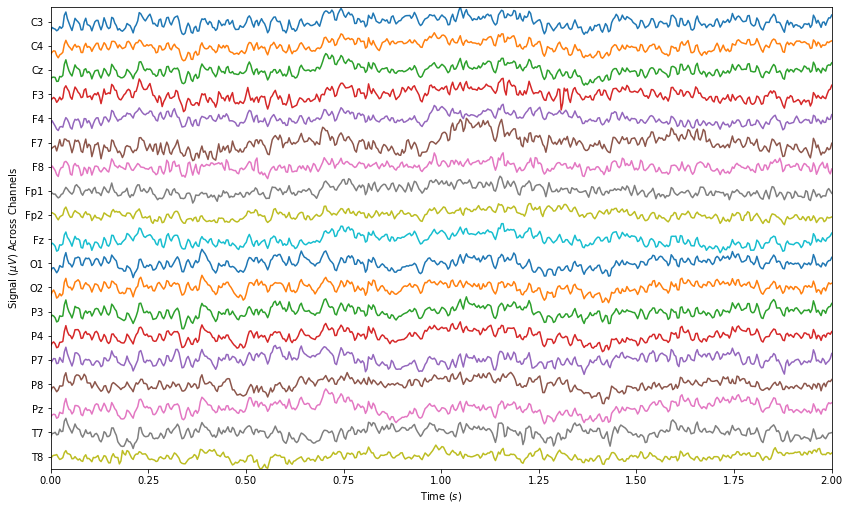

In [16]:
train_data.plot_trace(2)

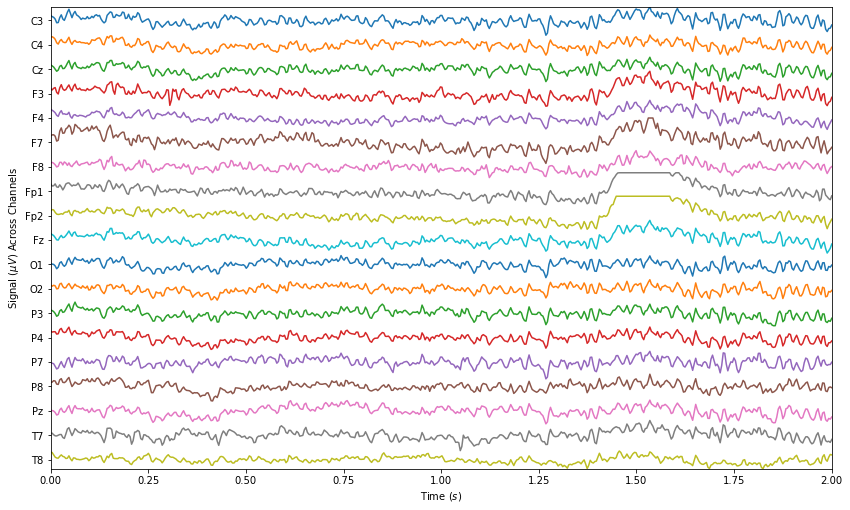

In [17]:
train_data.plot_trace(3)

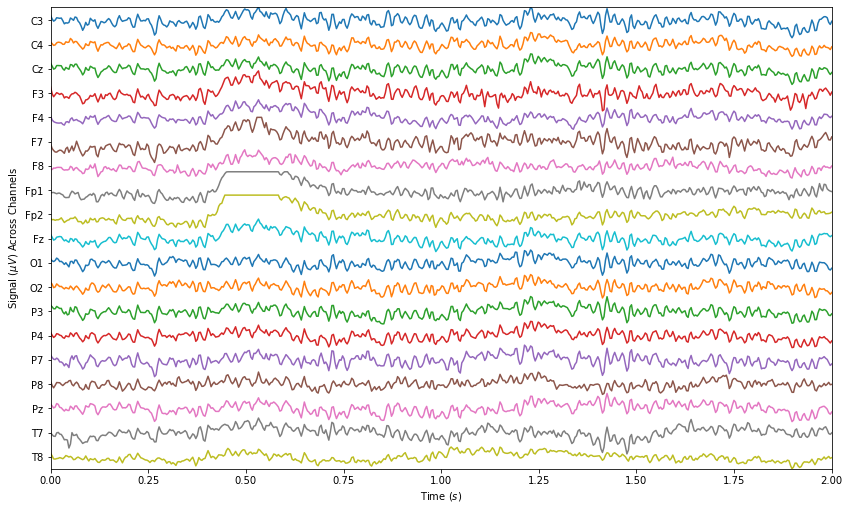

In [18]:
train_data.plot_trace(4)

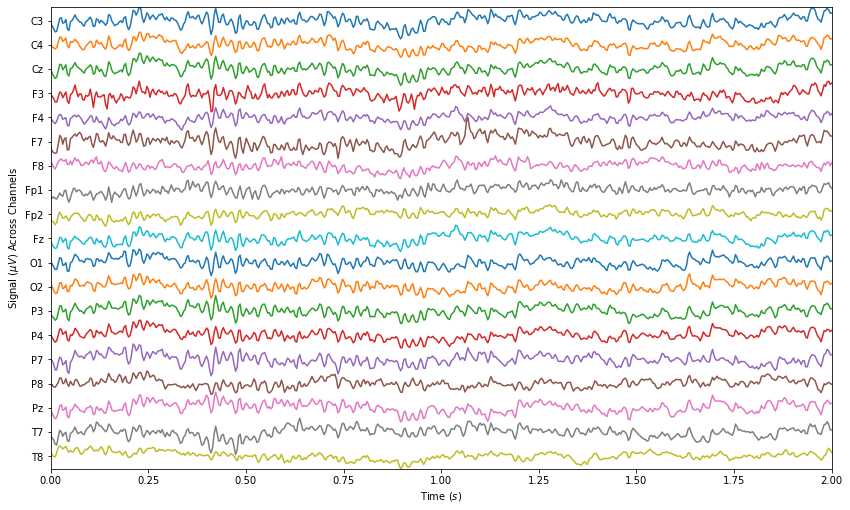

In [19]:
train_data.plot_trace(5)

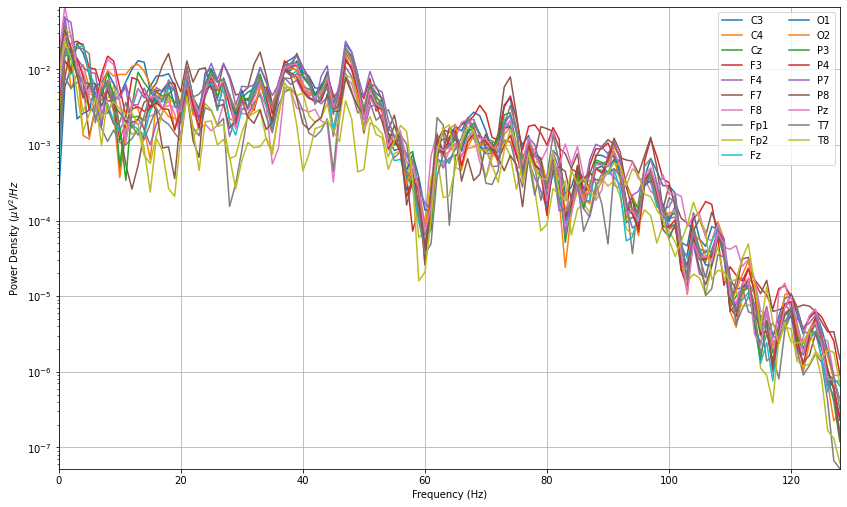

In [20]:
train_data.plot_psd(0)

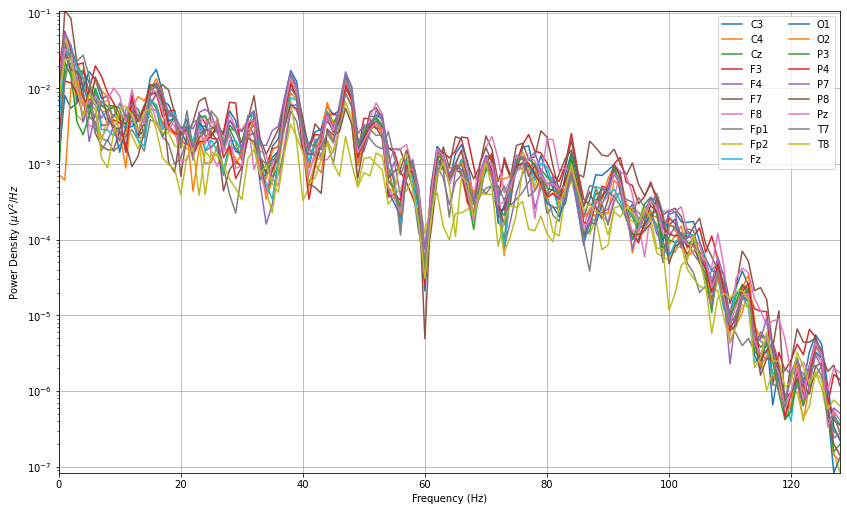

In [21]:
train_data.plot_psd(1)

## Autoencoder Networks

In [22]:
class ConvEncodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer):
        super().__init__()

        self.conv = th.nn.Conv1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)

        self.transfer = transfer()

    def forward(self, segs):
        assert segs.ndim == 3
        return self.transfer(self.conv(segs))

In [23]:
class ResidualEncodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer):
        super().__init__()
        
        #self.batch_norm = th.nn.BatchNorm1d(
        #    nchan, momentum=0.05)
            
        if nchan == nfilt:
            self.remix = lambda segs: segs
        else:
            self.remix = th.nn.Conv1d(nchan, nfilt, kernel_size=1)

        if stride == 1:
            self.downsample = lambda segs: segs
        else:
            self.downsample = th.nn.AvgPool1d(stride, ceil_mode=True)
        
        #self.pad = th.nn.ReflectionPad1d(kernel_size // 2)

        self.conv = th.nn.Conv1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)

        self.transfer = transfer()

        self.combine = th.nn.Conv1d(nfilt, nfilt, kernel_size=1)

    def forward(self, segs):
        assert segs.ndim == 3
        
        #norm_segs = self.batch_norm(segs)
        remix_out = self.downsample(self.remix(segs))
        resid_out = self.combine(self.transfer(self.conv(segs)))

        assert remix_out.shape == resid_out.shape
        return remix_out + resid_out

In [24]:
class Encoder(th.nn.Module):
    def __init__(self, nchan, nstep, conv_specs, transfer, block_arch):
        super().__init__()
        
        self.nchan, self.nstep = nchan, nstep

        self.output_shapes = [(nchan, nstep)]
        self.conv_specs = conv_specs
        
        if block_arch == 'conv':
            encode_block_class = ConvEncodeBlock
        elif block_arch == 'resid':
            encode_block_class = ResidualEncodeBlock
        else:
            raise ValueError(f'invalid `block_arch`: {block_arch}')

        convs = []
        layer_in, layer_out = None, self.nchan
        for nfilt, kernel_size, stride in self.conv_specs:
            layer_in, layer_out = layer_out, nfilt
        
            convs.append(
                encode_block_class(
                    layer_in, nfilt,
                    kernel_size=kernel_size,
                    stride=stride,
                    transfer=transfer))
            
            nstep = math.ceil(nstep / stride) #- kernel_size // 2
            self.output_shapes.append((layer_out, nstep))
            
        self.conv = th.nn.Sequential(*convs)
        
    def forward(self, segs):
        assert isinstance(segs, th.Tensor)

        assert segs.ndim == 3
        assert segs.shape[1] == self.nchan
        #assert segs.shape[2] == self.nstep
        batch_size = segs.shape[0]                                                                  

        conv_out = self.conv(segs)
        assert conv_out.ndim == 3
        assert conv_out.shape[0] == batch_size                                                 
        assert conv_out.shape[1] == self.output_shapes[-1][0] # nfilt
        #assert conv_out.shape[2] == self.output_shapes[-1][1] # nstep

        codes = conv_out.reshape(batch_size, -1)
        assert codes.ndim == 2
        assert codes.shape[0] == batch_size
        
        return codes

In [25]:
class ConvDecodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer, output_shape):
        super().__init__()
        self.output_shape = output_shape

        self.deconv = th.nn.ConvTranspose1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)
        
        self.transfer = transfer()
        
    def forward(self, segs):
        assert segs.ndim == 3
        return self.transfer(self.deconv(segs, self.output_shape))

In [26]:
class ResidualDecodeBlock(th.nn.Module):
    def __init__(self, nchan, nfilt, kernel_size, stride, transfer, output_shape):
        super().__init__()
        self.output_shape = output_shape
        
        #self.batch_norm = th.nn.BatchNorm1d(
        #    nchan, momentum=0.05)

        if nchan == nfilt:
            self.remix = lambda segs: segs
        else:
            self.remix = th.nn.Conv1d(nchan, nfilt, kernel_size=1)

        if stride == 1:
            self.upsample = lambda segs: segs
        else:
            self.upsample = th.nn.Upsample(
                size=self.output_shape,
                mode='linear',
                align_corners=False)

        self.deconv = th.nn.ConvTranspose1d(
            nchan, nfilt,
            kernel_size=kernel_size,
            padding=kernel_size // 2,
            stride=stride)
        
        self.transfer = transfer()

        self.combine = th.nn.Conv1d(nfilt, nfilt, kernel_size=1)
        
    def forward(self, segs):
        assert segs.ndim == 3
        
        #norm_segs = self.batch_norm(segs)
        remix_out = self.upsample(self.remix(segs))
        resid_out = self.combine(self.transfer(
            self.deconv(segs, self.output_shape)))

        assert remix_out.shape == resid_out.shape
        return remix_out + resid_out

In [27]:
class Decoder(th.nn.Module):
    def __init__(self, output_shapes, conv_specs, transfer, block_arch):
        super().__init__()
        
        self.output_shapes = output_shapes
        self.conv_specs = conv_specs
        
        if block_arch == 'conv':
            decode_block_class = ConvDecodeBlock
        elif block_arch == 'resid':
            decode_block_class = ResidualDecodeBlock
        else:
            raise ValueError(f'invalid `block_arch`: {block_arch}')

        deconvs = []
        layer_in, layer_out = None, output_shapes[0][0]
        for i, (nfilt, kernel_size, stride) in enumerate(self.conv_specs):
            layer_in, layer_out = layer_out, nfilt

            deconvs.append(
                decode_block_class(
                    layer_in, nfilt,
                    kernel_size=kernel_size,
                    stride=stride,
                    transfer=transfer,
                    output_shape=self.output_shapes[i+1][1:]))

        self.deconv = th.nn.Sequential(*deconvs)
        
        nchan, _nstep = self.output_shapes[-1]
        #self.readout = th.nn.Sequential(                                                            
        #    th.nn.BatchNorm1d(layer_out, momentum=0.05),
        #    th.nn.Conv1d(layer_out, nchan, kernel_size=1, padding=0))
        self.readout = th.nn.Conv1d(layer_out, nchan, kernel_size=1, padding=0)
    
    def forward(self, codes):
        assert isinstance(codes, th.Tensor)
        assert codes.ndim == 2
        batch_size = codes.shape[0]
                                                                                                    
        unflat_codes = codes.reshape((batch_size,) + self.output_shapes[0])
        assert unflat_codes.ndim == 3
        assert unflat_codes.shape[0] == batch_size
        assert unflat_codes.shape[1] == self.output_shapes[0][0] # nfilt
        assert unflat_codes.shape[2] == self.output_shapes[0][1] # nstep

        deconv_out = self.deconv(unflat_codes)                         
        assert deconv_out.ndim == 3
        assert deconv_out.shape[0] == batch_size
        assert deconv_out.shape[2] == self.output_shapes[-1][1] # nstep

        segs = self.readout(deconv_out)
        assert segs.ndim == 3
        assert segs.shape[0] == batch_size
        assert segs.shape[1] == self.output_shapes[-1][0] # nchan
        assert segs.shape[2] == self.output_shapes[-1][1] # nstep

        return segs

In [28]:
class Autoencoder(th.nn.Module):
    def __init__(self, nchan, nstep, conv_specs, transfer=th.nn.ReLU, block_arch='conv'):
        super().__init__()

        assert nchan > 0
        assert nstep > 0
        self.nchan, self.nstep = nchan, nstep

        assert isinstance(conv_specs, tuple)
        self.conv_specs = conv_specs

        assert issubclass(transfer, th.nn.Module)

        self.encoder = Encoder(
            nchan=self.nchan,
            nstep=self.nstep,
            conv_specs=self.conv_specs,
            transfer=transfer,
            block_arch=block_arch)

        rev_conv_specs = tuple(reversed(self.conv_specs))
        rev_output_shapes = tuple(reversed(self.encoder.output_shapes))

        self.decoder = Decoder(
            output_shapes=rev_output_shapes,
            conv_specs=rev_conv_specs,
            transfer=transfer,
            block_arch=block_arch)

    def forward(self, segs):
        return self.decoder(self.encoder(segs))

    @th.no_grad()
    def encode(self, segs):
        return self.encoder(segs)
    
    @th.no_grad()
    def recon(self, segs):
        return self(segs)
    
    @property
    def nparameters(self):
        return sum(p.nelement() for p in self.parameters())
    
    def save(self, filename):
        with open(filename, mode='wb') as fh:                                                  
            th.save(self.state_dict(), fh)

## Training

In [29]:
def train_adam(model, train_data, valid_data, max_epochs=500, stop_epochs=50,
               learning_rate=0.0125, learning_rate_decay=0.996, loss_method='huber',
               clip_norm=6, batch_size=128, load_workers=0, use_gpu=True):
    train_loader = th.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        drop_last=True,
        shuffle=True)

    valid_loader = th.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        shuffle=False)

    if use_gpu:
        model.cuda()

    train_losses = []
    valid_losses = []

    best_train_loss = float('inf')
    best_valid_loss = float('inf')
    best_epoch = 0
    best_state = None

    if loss_method == 'mse':
        loss_func = th.nn.MSELoss(reduction='mean')
    elif loss_method == 'huber':
        loss_func = th.nn.SmoothL1Loss(reduction='mean')
    else:
        raise ValueError(f'invalid `loss_method`: {loss_method}')
    
    # all parameters with `requires_grad` set
    parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
        
    # initialize the optimizer
    optimizer = th.optim.Adam(parameters, lr=learning_rate)
        
    # exponential learning rate decay
    lr_scheduler = th.optim.lr_scheduler.ExponentialLR(optimizer, learning_rate_decay)
        
    for epoch in range(max_epochs):                                                                                                    
        # enter training mode
        model.train()

        # training pass
        epoch_train_losses = []
        for i, segs in enumerate(train_loader):
            optimizer.zero_grad()
            
            if use_gpu:
                segs = segs.cuda()

            recons = model(segs)
            loss = loss_func(recons, segs)

            loss_f = loss.item()
            epoch_train_losses.append(loss_f)

            loss.backward()

            if clip_norm is not None:
                th.nn.utils.clip_grad_norm_(parameters, clip_norm)

            optimizer.step()

        train_losses.append(np.mean(epoch_train_losses))
            
        # back to evaluation mode
        model.eval()

        # validation loss
        with th.no_grad():
            epoch_valid_losses = []
            for i, segs in enumerate(valid_loader):
                if use_gpu:
                    segs = segs.cuda()

                recons = model(segs)
                loss = loss_func(recons, segs)

                loss_f = loss.item()
                epoch_valid_losses.append(loss_f)

        valid_losses.append(np.mean(epoch_valid_losses))
            
        if valid_losses[-1] < best_valid_loss:
            best_train_loss = train_losses[-1]
            best_valid_loss = valid_losses[-1]
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())

        print('epoch:', epoch)
        print('learning rate:', next(iter(optimizer.param_groups))['lr'])
        print('train loss:', train_losses[-1])
        print('valid loss:', valid_losses[-1])
        print('best epoch:', best_epoch)
        print('=======')
                
        if (best_epoch + stop_epochs) <= epoch:
            print(f'terminating after {stop_epochs} of no improvement')
            break

        lr_scheduler.step()

    if best_state is None:
        raise RuntimeError('best state not set!')

    model.load_state_dict(best_state)

    if use_gpu:
        model.cpu()

    return munch.munchify({
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'best_train_loss': best_train_loss,
        'best_valid_loss': best_valid_loss,
        'best_epoch': best_epoch,
    })

In [30]:
def train_rprop(model, train_data, valid_data, max_epochs=1500, stop_epochs=50,
                init_step=0.005, loss_method='huber', batch_size=128, load_workers=0,
                use_gpu=True):

    train_loader = th.utils.data.DataLoader(
        train_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        drop_last=False,
        shuffle=False)

    valid_loader = th.utils.data.DataLoader(
        valid_data,
        batch_size=batch_size,
        pin_memory=use_gpu,
        num_workers=load_workers,
        shuffle=False)

    if use_gpu:
        model.cuda()

    train_losses = []
    valid_losses = []

    best_train_loss = float('inf')
    best_valid_loss = float('inf')
    best_epoch = 0
    best_state = None

    if loss_method == 'mse':
        loss_func = th.nn.MSELoss(reduction='mean')
    elif loss_method == 'huber':
        loss_func = th.nn.SmoothL1Loss(reduction='mean')
    else:
        raise ValueError(f'invalid `loss_method`: {loss_method}')
    
    # all parameters with `requires_grad` set
    parameters = list(filter(lambda param: param.requires_grad, model.parameters()))
        
    # initialize the optimizer
    optimizer = th.optim.Rprop(parameters, lr=init_step)
        
    for epoch in range(max_epochs):                                                                                                    
        # enter training mode
        model.train()

        # zero gradients
        # outside of the batch loop since gradients are accumulated
        optimizer.zero_grad()
        
        # training pass
        epoch_train_losses = []
        for i, segs in enumerate(train_loader):
            if use_gpu:
                segs = segs.cuda()

            recons = model(segs)
            loss = loss_func(recons, segs)

            loss_f = loss.item()
            epoch_train_losses.append(loss_f)

            loss.backward()

        optimizer.step()

        train_losses.append(np.mean(epoch_train_losses))
            
        # back to evaluation mode
        model.eval()

        # validation loss
        with th.no_grad():
            epoch_valid_losses = []
            for i, segs in enumerate(valid_loader):
                if use_gpu:
                    segs = segs.cuda()

                recons = model(segs)
                loss = loss_func(recons, segs)

                loss_f = loss.item()
                epoch_valid_losses.append(loss_f)

        valid_losses.append(np.mean(epoch_valid_losses))
            
        if valid_losses[-1] < best_valid_loss:
            best_train_loss = train_losses[-1]
            best_valid_loss = valid_losses[-1]
            best_epoch = epoch
            best_state = copy.deepcopy(model.state_dict())

        print('epoch:', epoch)
        print('train loss:', train_losses[-1])
        print('valid loss:', valid_losses[-1])
        print('best epoch:', best_epoch)
        print('=======')
                
        if (best_epoch + stop_epochs) <= epoch:
            print(f'terminating after {stop_epochs} of no improvement')
            break

    if best_state is None:
        raise RuntimeError('best state not set!')

    model.load_state_dict(best_state)

    if use_gpu:
        model.cpu()

    return munch.munchify({
        'train_losses': train_losses,
        'valid_losses': valid_losses,
        'best_train_loss': best_train_loss,
        'best_valid_loss': best_valid_loss,
        'best_epoch': best_epoch,
    })

In [31]:
def train(model, train_data, valid_data, optim_method='rprop', **kwargs):
    if optim_method == 'rprop':
        return train_rprop(model, train_data, valid_data, **kwargs)
    elif optim_method == 'adam':
        return train_adam(model, train_data, valid_data, **kwargs)
    else:
        raise ValueError(f'invalid `optim_method`: {optim_method}')

In [32]:
autoencoder = Autoencoder(
    nchan=train_data.nchan,
    nstep=train_data.nstep,
    #conv_specs=((32, 21, 1), (32, 19, 2),  # 128Hz
    #            (48, 17, 1), (48, 15, 2),  # 64Hz
    #            (64, 13, 1), (64, 11, 2),  # 32Hz
    #            (80,  9, 1), (80,  7, 2),  # 16Hz
    #            (96,  5, 1), (96,  3, 2)),  # 8Hz
    #            #(72,  3, 1), (72,  3, 2)), # 4Hz
    #conv_specs=(
    #    (32, 19, 2),  # 128Hz
    #    (48, 15, 2),  # 64Hz
    #    (64, 11, 2),  # 32Hz
    #    (80,  7, 2),  # 16Hz
    #    (96,  5, 2),  # 8Hz
    #    (112, 3, 2)), # 4Hz
    #conv_specs=((32, 11, 1), (32, 11, 1), (32, 11, 2), # 128Hz
    #            (48,  9, 1), (48,  9, 1), (48,  9, 2), # 64Hz
    #            (64,  7, 1), (64,  7, 1), (64,  7, 2), # 32Hz
    #            (80,  5, 1), (80,  5, 1), (80,  5, 2), # 16Hz
    #           ),
    #conv_specs=((32, 11, 2), # 128Hz
    #            (48,  9, 2), # 64Hz
    #            (64,  7, 2), # 32Hz
    #             (80,  5, 2), # 16Hz
    #            ),
    #conv_specs=((32, 11, 2), # 128Hz
    #            (40,  9, 2), # 64Hz
    #            (48,  7, 2), # 32Hz
    #            (56,  5, 2), # 16Hz
    #            (64,  3, 2), #  8Hz
    #           ),
    conv_specs=((24, 11, 2), # 128Hz
                (32,  9, 2), # 64Hz
                (40,  7, 2), # 32Hz
                (48,  5, 2), # 16Hz
               ),
    block_arch='resid',
    transfer=th.nn.ReLU)

autoencoder

Autoencoder(
  (encoder): Encoder(
    (conv): Sequential(
      (0): ResidualEncodeBlock(
        (remix): Conv1d(19, 24, kernel_size=(1,), stride=(1,))
        (downsample): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
        (conv): Conv1d(19, 24, kernel_size=(11,), stride=(2,), padding=(5,))
        (transfer): ReLU()
        (combine): Conv1d(24, 24, kernel_size=(1,), stride=(1,))
      )
      (1): ResidualEncodeBlock(
        (remix): Conv1d(24, 32, kernel_size=(1,), stride=(1,))
        (downsample): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
        (conv): Conv1d(24, 32, kernel_size=(9,), stride=(2,), padding=(4,))
        (transfer): ReLU()
        (combine): Conv1d(32, 32, kernel_size=(1,), stride=(1,))
      )
      (2): ResidualEncodeBlock(
        (remix): Conv1d(32, 40, kernel_size=(1,), stride=(1,))
        (downsample): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
        (conv): Conv1d(32, 40, kernel_size=(7,), stride=(2,), padding=(3

Total number of parameters in the autoencoder:

In [33]:
sum(p.nelement() for p in autoencoder.parameters())

96107

In [34]:
first_segment = train_data[0][None, ...]

In [35]:
first_segment.shape, first_segment.shape[0] * first_segment.shape[1]

(torch.Size([1, 19, 512]), 19)

In [36]:
autoencoder.eval()
autoencoder.encode(first_segment).shape

torch.Size([1, 1536])

In [37]:
autoencoder.encoder.output_shapes

[(19, 512), (24, 256), (32, 128), (40, 64), (48, 32)]

In [38]:
recon = autoencoder.recon(first_segment)
recon.shape, recon.min(), recon.max()

(torch.Size([1, 19, 512]), tensor(-0.3372), tensor(0.3437))

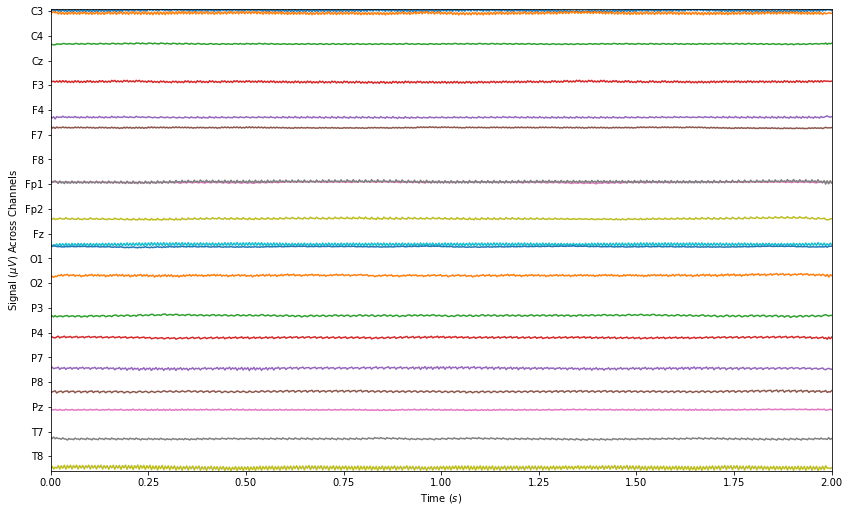

In [39]:
train_data.plot_trace(recon[0])

In [40]:
train_result = train(autoencoder, train_data, valid_data, optim_method='rprop', loss_method='huber', use_gpu=False)

epoch: 0
train loss: 0.3519292790212749
valid loss: 0.2404336966574192
best epoch: 0
epoch: 1
train loss: 0.33484673086139893
valid loss: 0.2652034175892671
best epoch: 0
epoch: 2
train loss: 0.36373437094835587
valid loss: 0.18885906164844832
best epoch: 2
epoch: 3
train loss: 0.2619668830324102
valid loss: 0.24536302934090296
best epoch: 2
epoch: 4
train loss: 0.3470724161576342
valid loss: 0.175558403134346
best epoch: 4
epoch: 5
train loss: 0.24878019903912957
valid loss: 0.21418170382579169
best epoch: 4
epoch: 6
train loss: 0.2933356237632257
valid loss: 0.1899312362074852
best epoch: 4
epoch: 7
train loss: 0.2618975754321357
valid loss: 0.16888864152133465
best epoch: 7
epoch: 8
train loss: 0.23779664676130555
valid loss: 0.16766771922508875
best epoch: 8
epoch: 9
train loss: 0.24536670565053267
valid loss: 0.15924314657847086
best epoch: 9
epoch: 10
train loss: 0.23097897822290292
valid loss: 0.1519436084975799
best epoch: 10
epoch: 11
train loss: 0.21561033609840605
valid loss

epoch: 86
train loss: 0.1348157988079352
valid loss: 0.09013295421997707
best epoch: 86
epoch: 87
train loss: 0.13444915865720422
valid loss: 0.08987699014445145
best epoch: 87
epoch: 88
train loss: 0.13408070161110824
valid loss: 0.08975908812135458
best epoch: 88
epoch: 89
train loss: 0.1337205855589774
valid loss: 0.08958730722467105
best epoch: 89
epoch: 90
train loss: 0.13335413759413325
valid loss: 0.08939941258480151
best epoch: 90
epoch: 91
train loss: 0.13298286366517897
valid loss: 0.0892857713624835
best epoch: 91
epoch: 92
train loss: 0.1326202401707386
valid loss: 0.08911892864853144
best epoch: 92
epoch: 93
train loss: 0.13225818095429812
valid loss: 0.08889074965069692
best epoch: 93
epoch: 94
train loss: 0.13189695782407565
valid loss: 0.08869586295137803
best epoch: 94
epoch: 95
train loss: 0.1315414948089991
valid loss: 0.08847203198820353
best epoch: 95
epoch: 96
train loss: 0.1312064920655555
valid loss: 0.08841258256385724
best epoch: 96
epoch: 97
train loss: 0.130

epoch: 170
train loss: 0.10792075462041446
valid loss: 0.07618350225190322
best epoch: 170
epoch: 171
train loss: 0.10772638103384295
valid loss: 0.07608196729173262
best epoch: 171
epoch: 172
train loss: 0.10753585169390764
valid loss: 0.07593227364122868
best epoch: 172
epoch: 173
train loss: 0.10734908862246408
valid loss: 0.07583351743717988
best epoch: 173
epoch: 174
train loss: 0.1071651965080772
valid loss: 0.07577955070883036
best epoch: 174
epoch: 175
train loss: 0.10699316121085926
valid loss: 0.07560405476639669
best epoch: 175
epoch: 176
train loss: 0.10682726397328539
valid loss: 0.07556098885834217
best epoch: 176
epoch: 177
train loss: 0.1066615207373728
valid loss: 0.07540871482342482
best epoch: 177
epoch: 178
train loss: 0.10649845688201395
valid loss: 0.07531197275966406
best epoch: 178
epoch: 179
train loss: 0.10633550656752454
valid loss: 0.07517431676387787
best epoch: 179
epoch: 180
train loss: 0.10617423965883108
valid loss: 0.07504943789293368
best epoch: 180
e

epoch: 254
train loss: 0.09582529755102263
valid loss: 0.0703937237461408
best epoch: 254
epoch: 255
train loss: 0.09568736618269741
valid loss: 0.07032817633201678
best epoch: 255
epoch: 256
train loss: 0.09555788841788415
valid loss: 0.07032434766491254
best epoch: 256
epoch: 257
train loss: 0.09542893559706432
valid loss: 0.0703099196155866
best epoch: 257
epoch: 258
train loss: 0.09530235043968316
valid loss: 0.07028749585151672
best epoch: 258
epoch: 259
train loss: 0.09517063178627948
valid loss: 0.07026491779834032
best epoch: 259
epoch: 260
train loss: 0.09503659507098758
valid loss: 0.07024055284758408
best epoch: 260
epoch: 261
train loss: 0.09489542539059012
valid loss: 0.07020301092416048
best epoch: 261
epoch: 262
train loss: 0.09475126073776204
valid loss: 0.0701703770707051
best epoch: 262
epoch: 263
train loss: 0.09459735768168796
valid loss: 0.07014116458594799
best epoch: 263
epoch: 264
train loss: 0.09443930941231457
valid loss: 0.07010872972508271
best epoch: 264
ep

epoch: 337
train loss: 0.08253031814999787
valid loss: 0.06686531069378059
best epoch: 337
epoch: 338
train loss: 0.08242158707875161
valid loss: 0.06681773128608863
best epoch: 338
epoch: 339
train loss: 0.08231099990460976
valid loss: 0.06677747269471486
best epoch: 339
epoch: 340
train loss: 0.08219750546332863
valid loss: 0.06673673850794633
best epoch: 340
epoch: 341
train loss: 0.08208084781366734
valid loss: 0.06669996989270051
best epoch: 341
epoch: 342
train loss: 0.08196268912496758
valid loss: 0.06663163689275582
best epoch: 342
epoch: 343
train loss: 0.08184739692067658
valid loss: 0.06660479369262855
best epoch: 343
epoch: 344
train loss: 0.08173947712337529
valid loss: 0.06653822089234988
best epoch: 344
epoch: 345
train loss: 0.0816347068865542
valid loss: 0.06650629794845979
best epoch: 345
epoch: 346
train loss: 0.08153367088532743
valid loss: 0.06646898450950782
best epoch: 346
epoch: 347
train loss: 0.08143249496725606
valid loss: 0.06642462126910686
best epoch: 347


epoch: 420
train loss: 0.07576239336695936
valid loss: 0.06415257633974154
best epoch: 420
epoch: 421
train loss: 0.07569730190997138
valid loss: 0.06411026852826278
best epoch: 421
epoch: 422
train loss: 0.07563320746254405
valid loss: 0.06409974054743846
best epoch: 422
epoch: 423
train loss: 0.07557192217144701
valid loss: 0.06405474555989106
best epoch: 423
epoch: 424
train loss: 0.0755123968500598
valid loss: 0.06405256688594818
best epoch: 424
epoch: 425
train loss: 0.07545535257201136
valid loss: 0.06403222338606913
best epoch: 425
epoch: 426
train loss: 0.07539752007312613
valid loss: 0.06401276029646397
best epoch: 426
epoch: 427
train loss: 0.07534305614499766
valid loss: 0.06398896748820941
best epoch: 427
epoch: 428
train loss: 0.07529031550856652
valid loss: 0.06398049959292014
best epoch: 428
epoch: 429
train loss: 0.07523524893424761
valid loss: 0.06396342410395543
best epoch: 429
epoch: 430
train loss: 0.07517903720109183
valid loss: 0.06395008942733209
best epoch: 430


epoch: 503
train loss: 0.0722995258545802
valid loss: 0.06291980079064767
best epoch: 503
epoch: 504
train loss: 0.07226963378029105
valid loss: 0.06290266538659732
best epoch: 504
epoch: 505
train loss: 0.0722406546090856
valid loss: 0.0628874571993947
best epoch: 505
epoch: 506
train loss: 0.0722110850483547
valid loss: 0.06286058357606332
best epoch: 506
epoch: 507
train loss: 0.07218206507142311
valid loss: 0.0628427630290389
best epoch: 507
epoch: 508
train loss: 0.07215325597581672
valid loss: 0.06283069495111704
best epoch: 508
epoch: 509
train loss: 0.07212438386071611
valid loss: 0.06282440790285666
best epoch: 509
epoch: 510
train loss: 0.07209605122284021
valid loss: 0.0628117589900891
best epoch: 510
epoch: 511
train loss: 0.07206659589284732
valid loss: 0.0627933545038104
best epoch: 511
epoch: 512
train loss: 0.07203801684541467
valid loss: 0.06278713947782914
best epoch: 512
epoch: 513
train loss: 0.07201182680135523
valid loss: 0.06276444345712662
best epoch: 513
epoch:

epoch: 586
train loss: 0.07034622993964104
valid loss: 0.062135426017145313
best epoch: 586
epoch: 587
train loss: 0.07032817804519041
valid loss: 0.06213804893195629
best epoch: 586
epoch: 588
train loss: 0.07031105059762428
valid loss: 0.062127585522830486
best epoch: 588
epoch: 589
train loss: 0.07029289401561757
valid loss: 0.06212082256873449
best epoch: 589
epoch: 590
train loss: 0.0702744545645
valid loss: 0.06211299014588197
best epoch: 590
epoch: 591
train loss: 0.07025644138317418
valid loss: 0.06210816434274117
best epoch: 591
epoch: 592
train loss: 0.07023769415869022
valid loss: 0.062096090987324715
best epoch: 592
epoch: 593
train loss: 0.07021920893479276
valid loss: 0.06208922372510036
best epoch: 593
epoch: 594
train loss: 0.07020130952429256
valid loss: 0.06208482043196758
best epoch: 594
epoch: 595
train loss: 0.07018375416274791
valid loss: 0.062074777049322925
best epoch: 595
epoch: 596
train loss: 0.0701655343082952
valid loss: 0.062068469201525055
best epoch: 596

epoch: 669
train loss: 0.06903983019062399
valid loss: 0.06151784242441257
best epoch: 668
epoch: 670
train loss: 0.06902700209599218
valid loss: 0.06150594539940357
best epoch: 670
epoch: 671
train loss: 0.06901323601005623
valid loss: 0.06151050142943859
best epoch: 670
epoch: 672
train loss: 0.0690002687919287
valid loss: 0.061497767455875874
best epoch: 672
epoch: 673
train loss: 0.06898659452749992
valid loss: 0.06149824863920609
best epoch: 672
epoch: 674
train loss: 0.06897295820584268
valid loss: 0.06148730808248123
best epoch: 674
epoch: 675
train loss: 0.06895892328962132
valid loss: 0.06148188405980667
best epoch: 675
epoch: 676
train loss: 0.06894471304330194
valid loss: 0.06147832361360391
best epoch: 676
epoch: 677
train loss: 0.06893090461093335
valid loss: 0.061470553278923035
best epoch: 677
epoch: 678
train loss: 0.06891669055883899
valid loss: 0.06146576379736265
best epoch: 678
epoch: 679
train loss: 0.06890268897476756
valid loss: 0.061463783184687294
best epoch: 6

epoch: 752
train loss: 0.06801658860741207
valid loss: 0.06115115371843179
best epoch: 752
epoch: 753
train loss: 0.0680047920272674
valid loss: 0.06114794903745254
best epoch: 753
epoch: 754
train loss: 0.06799327293525875
valid loss: 0.06113750208169222
best epoch: 754
epoch: 755
train loss: 0.06798055493215352
valid loss: 0.061132844227055706
best epoch: 755
epoch: 756
train loss: 0.0679679417890715
valid loss: 0.06112584720055262
best epoch: 756
epoch: 757
train loss: 0.06795462282995383
valid loss: 0.06111620273441076
best epoch: 757
epoch: 758
train loss: 0.06794349252487775
valid loss: 0.06111921525249878
best epoch: 757
epoch: 759
train loss: 0.06793182974474297
valid loss: 0.06111337927480539
best epoch: 759
epoch: 760
train loss: 0.06792159884432215
valid loss: 0.06111176467190186
best epoch: 760
epoch: 761
train loss: 0.06791162910514775
valid loss: 0.06110721050451199
best epoch: 761
epoch: 762
train loss: 0.06790130940714369
valid loss: 0.06110087192306916
best epoch: 762


epoch: 835
train loss: 0.06711605237796903
valid loss: 0.060772642803688846
best epoch: 835
epoch: 836
train loss: 0.0671053169709113
valid loss: 0.06076945085078478
best epoch: 836
epoch: 837
train loss: 0.06709523378859883
valid loss: 0.06076386943459511
best epoch: 837
epoch: 838
train loss: 0.06708487669971806
valid loss: 0.06075884153445562
best epoch: 838
epoch: 839
train loss: 0.06707412670768889
valid loss: 0.06075631454586983
best epoch: 839
epoch: 840
train loss: 0.0670640164365371
valid loss: 0.06074722918371359
best epoch: 840
epoch: 841
train loss: 0.06705355905801241
valid loss: 0.060745641899605594
best epoch: 841
epoch: 842
train loss: 0.06704301234150742
valid loss: 0.060740395759542785
best epoch: 842
epoch: 843
train loss: 0.06703277212211195
valid loss: 0.06073817145079374
best epoch: 843
epoch: 844
train loss: 0.06702242956071357
valid loss: 0.06073049704233805
best epoch: 844
epoch: 845
train loss: 0.0670126132885523
valid loss: 0.06073056751241287
best epoch: 844

epoch: 918
train loss: 0.06629117511005865
valid loss: 0.06040627943972746
best epoch: 918
epoch: 919
train loss: 0.06628144559461946
valid loss: 0.06041353972007831
best epoch: 918
epoch: 920
train loss: 0.06627433986207586
valid loss: 0.0604017653192083
best epoch: 920
epoch: 921
train loss: 0.06626431751467379
valid loss: 0.06040283478796482
best epoch: 920
epoch: 922
train loss: 0.06625652486274455
valid loss: 0.06039713012675444
best epoch: 922
epoch: 923
train loss: 0.0662466148144485
valid loss: 0.06039393755296866
best epoch: 923
epoch: 924
train loss: 0.06623789843424786
valid loss: 0.06038930515448252
best epoch: 924
epoch: 925
train loss: 0.06622832396102173
valid loss: 0.06038642426331838
best epoch: 925
epoch: 926
train loss: 0.06621927991049525
valid loss: 0.06038418567428986
best epoch: 926
epoch: 927
train loss: 0.06621001789599289
valid loss: 0.0603820870940884
best epoch: 927
epoch: 928
train loss: 0.0662014506481312
valid loss: 0.06037676054984331
best epoch: 928
epo

epoch: 1001
train loss: 0.06557163190280582
valid loss: 0.06015130629142126
best epoch: 1001
epoch: 1002
train loss: 0.06556434240077197
valid loss: 0.0601468162300686
best epoch: 1002
epoch: 1003
train loss: 0.06555549796946623
valid loss: 0.060145258282621704
best epoch: 1003
epoch: 1004
train loss: 0.06554736923656346
valid loss: 0.060139411905159555
best epoch: 1004
epoch: 1005
train loss: 0.06553873100122552
valid loss: 0.06013754398251573
best epoch: 1005
epoch: 1006
train loss: 0.06553124440948904
valid loss: 0.06013348946968714
best epoch: 1006
epoch: 1007
train loss: 0.06552233520527313
valid loss: 0.060128556564450264
best epoch: 1007
epoch: 1008
train loss: 0.06551447828058843
valid loss: 0.06012223024542133
best epoch: 1008
epoch: 1009
train loss: 0.06550534351234451
valid loss: 0.06011826591566205
best epoch: 1009
epoch: 1010
train loss: 0.06549771501464241
valid loss: 0.06010818233092626
best epoch: 1010
epoch: 1011
train loss: 0.06548837090003086
valid loss: 0.0601065973

epoch: 1082
train loss: 0.06495924081860317
valid loss: 0.05992633601029714
best epoch: 1082
epoch: 1083
train loss: 0.06495188411187243
valid loss: 0.05992302360634009
best epoch: 1083
epoch: 1084
train loss: 0.06494488997706845
valid loss: 0.05992134908835093
best epoch: 1084
epoch: 1085
train loss: 0.06493776833730532
valid loss: 0.059920345122615494
best epoch: 1085
epoch: 1086
train loss: 0.06493159027103289
valid loss: 0.05991443137948712
best epoch: 1086
epoch: 1087
train loss: 0.06492404775969961
valid loss: 0.05991571101670464
best epoch: 1086
epoch: 1088
train loss: 0.06491790292209682
valid loss: 0.059911667524526514
best epoch: 1088
epoch: 1089
train loss: 0.06491021246269897
valid loss: 0.05991322407498956
best epoch: 1088
epoch: 1090
train loss: 0.06490422316746396
valid loss: 0.05990873618672291
best epoch: 1090
epoch: 1091
train loss: 0.06489603996943728
valid loss: 0.05990568005169431
best epoch: 1091
epoch: 1092
train loss: 0.06488995171830426
valid loss: 0.0599009147

epoch: 1164
train loss: 0.06443560781693201
valid loss: 0.05973937828093767
best epoch: 1164
epoch: 1165
train loss: 0.06443028242246789
valid loss: 0.05974023090675473
best epoch: 1164
epoch: 1166
train loss: 0.06442531695543433
valid loss: 0.059734787015865244
best epoch: 1166
epoch: 1167
train loss: 0.0644201501445086
valid loss: 0.05973623956864079
best epoch: 1166
epoch: 1168
train loss: 0.0644149694442289
valid loss: 0.059731853970636926
best epoch: 1168
epoch: 1169
train loss: 0.06440925835574299
valid loss: 0.05973494673768679
best epoch: 1168
epoch: 1170
train loss: 0.0644046584788112
valid loss: 0.0597288622520864
best epoch: 1170
epoch: 1171
train loss: 0.0643984987055538
valid loss: 0.0597330373711884
best epoch: 1170
epoch: 1172
train loss: 0.06439388958438311
valid loss: 0.059729337226599455
best epoch: 1170
epoch: 1173
train loss: 0.06438766955685468
valid loss: 0.05973258117834727
best epoch: 1170
epoch: 1174
train loss: 0.0643828923434571
valid loss: 0.0597304144563774

epoch: 1246
train loss: 0.0640004195364905
valid loss: 0.05961269186809659
best epoch: 1246
epoch: 1247
train loss: 0.06399429634351421
valid loss: 0.05961370002478361
best epoch: 1246
epoch: 1248
train loss: 0.06399020963681885
valid loss: 0.05960999211917321
best epoch: 1248
epoch: 1249
train loss: 0.06398423910026013
valid loss: 0.059611343002567686
best epoch: 1248
epoch: 1250
train loss: 0.06398055527106296
valid loss: 0.05960815896590551
best epoch: 1250
epoch: 1251
train loss: 0.0639743778946591
valid loss: 0.05960613116621971
best epoch: 1251
epoch: 1252
train loss: 0.06397063455279962
valid loss: 0.0596015932969749
best epoch: 1252
epoch: 1253
train loss: 0.06396470342498319
valid loss: 0.0596052206431826
best epoch: 1252
epoch: 1254
train loss: 0.06396101124837626
valid loss: 0.05960054276511073
best epoch: 1254
epoch: 1255
train loss: 0.06395478324711691
valid loss: 0.059600663681825004
best epoch: 1254
epoch: 1256
train loss: 0.06395096021393935
valid loss: 0.05959621661653

epoch: 1328
train loss: 0.06356837640711922
valid loss: 0.05948963978638252
best epoch: 1328
epoch: 1329
train loss: 0.06356228284974709
valid loss: 0.05949117600296935
best epoch: 1328
epoch: 1330
train loss: 0.06355641908184798
valid loss: 0.05948802533869942
best epoch: 1330
epoch: 1331
train loss: 0.06355022115885843
valid loss: 0.05948978398616115
best epoch: 1330
epoch: 1332
train loss: 0.06354526371154705
valid loss: 0.05948656890541315
best epoch: 1332
epoch: 1333
train loss: 0.0635382248962551
valid loss: 0.059486257998893656
best epoch: 1333
epoch: 1334
train loss: 0.06353302570749764
valid loss: 0.05948370757202307
best epoch: 1334
epoch: 1335
train loss: 0.0635263288313132
valid loss: 0.059484194964170456
best epoch: 1334
epoch: 1336
train loss: 0.06352087947321527
valid loss: 0.059482564528783165
best epoch: 1336
epoch: 1337
train loss: 0.06351410683221471
valid loss: 0.05948238323132197
best epoch: 1337
epoch: 1338
train loss: 0.0635086131328142
valid loss: 0.059480925556

epoch: 1410
train loss: 0.0631010735143022
valid loss: 0.0593754251797994
best epoch: 1410
epoch: 1411
train loss: 0.06309462683620276
valid loss: 0.05937653717895349
best epoch: 1410
epoch: 1412
train loss: 0.06309063170381167
valid loss: 0.05937063414603472
best epoch: 1412
epoch: 1413
train loss: 0.06308359461319116
valid loss: 0.05937350650007526
best epoch: 1412
epoch: 1414
train loss: 0.06308019066367436
valid loss: 0.05936677490050594
best epoch: 1414
epoch: 1415
train loss: 0.06307267574708403
valid loss: 0.05936996157591542
best epoch: 1414
epoch: 1416
train loss: 0.06306867115774456
valid loss: 0.059363070564965405
best epoch: 1416
epoch: 1417
train loss: 0.06306114616332414
valid loss: 0.05936586298048496
best epoch: 1416
epoch: 1418
train loss: 0.06305641824103615
valid loss: 0.0593596895535787
best epoch: 1418
epoch: 1419
train loss: 0.06304921761132133
valid loss: 0.05936358806987604
best epoch: 1418
epoch: 1420
train loss: 0.06304420415243064
valid loss: 0.05935635945449

epoch: 1492
train loss: 0.06266484553868204
valid loss: 0.05926217030112942
best epoch: 1492
epoch: 1493
train loss: 0.06265833521445777
valid loss: 0.059269494377076626
best epoch: 1492
epoch: 1494
train loss: 0.06265566154831538
valid loss: 0.059261545383681856
best epoch: 1494
epoch: 1495
train loss: 0.06264894555702254
valid loss: 0.05926712229847908
best epoch: 1494
epoch: 1496
train loss: 0.06264554618363395
valid loss: 0.059258469846099615
best epoch: 1496
epoch: 1497
train loss: 0.06263909897663528
valid loss: 0.059264397248625755
best epoch: 1496
epoch: 1498
train loss: 0.06263487574494915
valid loss: 0.05925584708650907
best epoch: 1498
epoch: 1499
train loss: 0.06262838622026237
valid loss: 0.05926056997850537
best epoch: 1498


In [41]:
autoencoder.save('conv_only_autoencoder_rprop.pkl')

(0.0, 1.0)

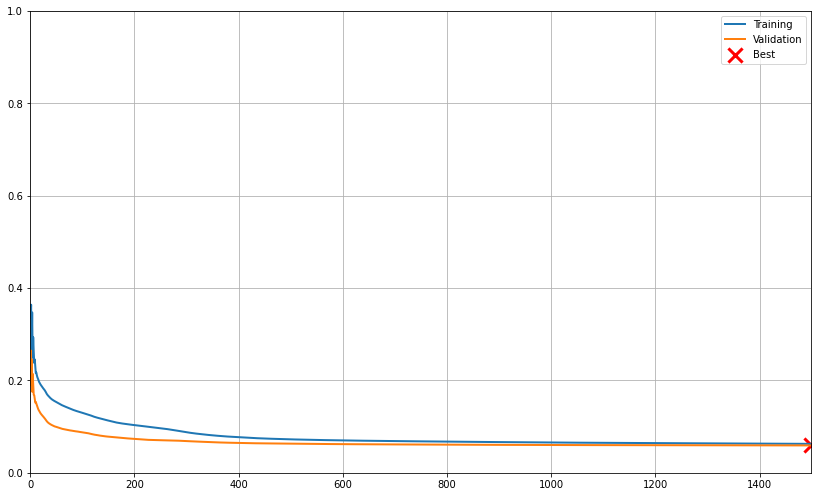

In [42]:
fig_loss = plt.figure()
ax_loss = fig_loss.add_subplot(1, 1, 1)
ax_loss.plot(train_result.train_losses, linewidth=2, label='Training')
ax_loss.plot(train_result.valid_losses, linewidth=2, label='Validation')
ax_loss.scatter(
    (train_result.best_epoch,), (train_result.best_valid_loss,),
    linewidth=3, s=200, marker='x', color='red', label='Best')
ax_loss.legend()
ax_loss.autoscale(tight=True)
ax_loss.grid();
ax_loss.set_ylim((0.0, 1.0))

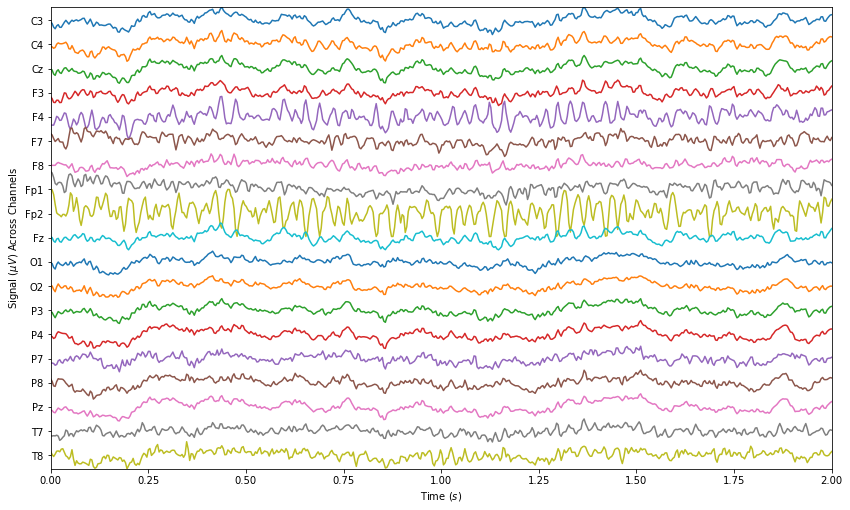

In [43]:
first_segment = valid_data[0]
valid_data.plot_trace(first_segment)

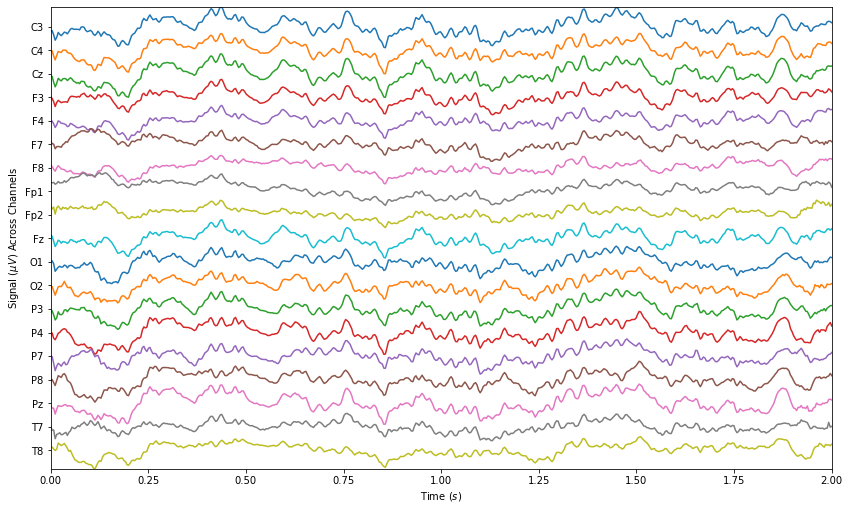

In [44]:
recon = autoencoder.recon(first_segment[None, ...])
valid_data.plot_trace(recon[0])

an encoded segment

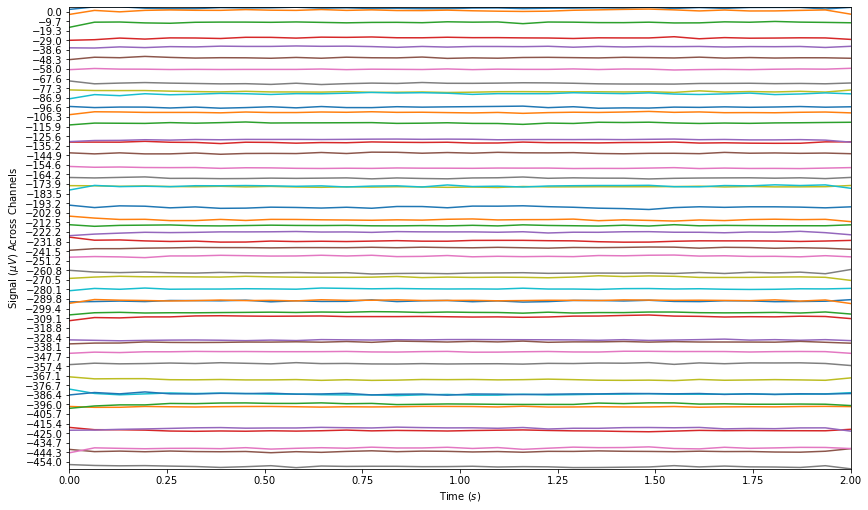

In [45]:
encoded_flat = autoencoder.encode(first_segment[None, ...])
encoded = encoded_flat.reshape(autoencoder.conv_specs[-1][0], -1)

# need to make plot_trace free standing

def plot_trace(segment, samp_rate, chan_names=None, scale_factor=0.75):
    segment = segment.T
        
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    
    nsec = segment.shape[0] / samp_rate
    
    nchan = segment.shape[1]
    
    scale = th.max(th.abs(segment))                                                                                                                                                                   
    sep = -th.arange(segment.shape[1]) * scale_factor * scale
    segment = segment + sep
        
    time = th.linspace(0, nsec, segment.shape[0])
    
    ax.plot(time, segment)
    ax.set_xlabel(r'Time ($s$)')
    ax.set_ylabel(r'Signal ($\mu V$) Across Channels')
    ax.set_yticks(sep)
    if chan_names:
        ax.set_yticklabels([c for i, c in enumerate(chan_names)])
    ax.autoscale(tight=True)
        
# samp rate assumes 2-second segments
plot_trace(encoded, samp_rate=encoded.shape[1] / 2.0)

the residuals

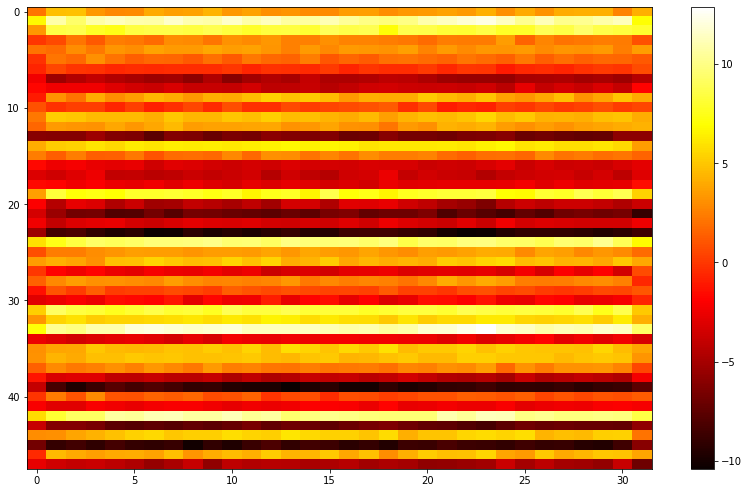

In [46]:
plt.imshow(encoded, aspect='auto', interpolation='none', cmap=plt.cm.hot);
plt.colorbar();

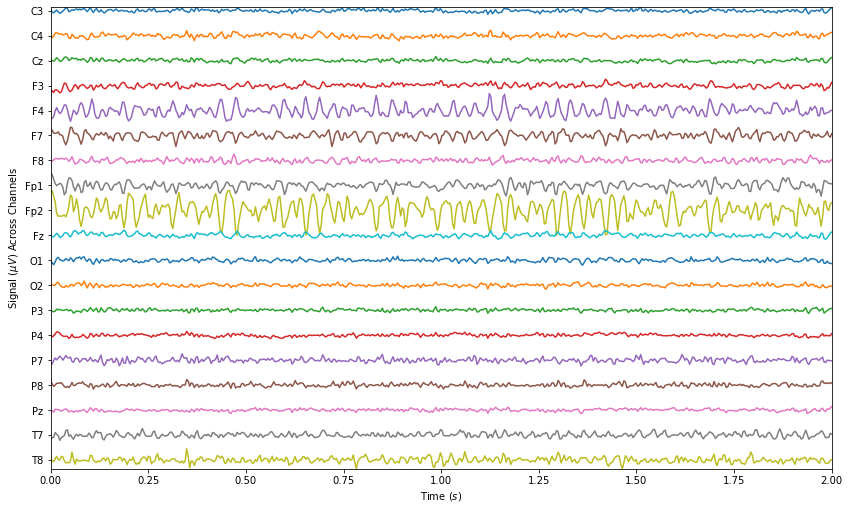

In [47]:
valid_data.plot_trace(first_segment - recon[0])

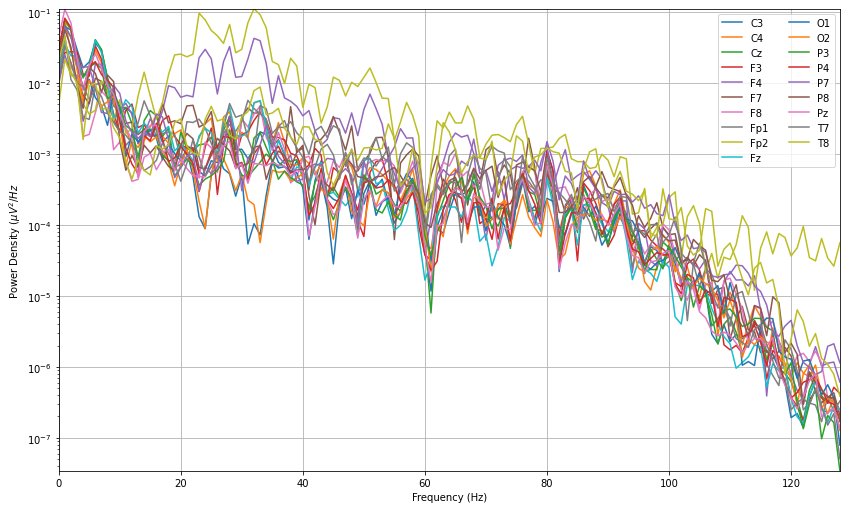

In [48]:
valid_data.plot_psd(first_segment)

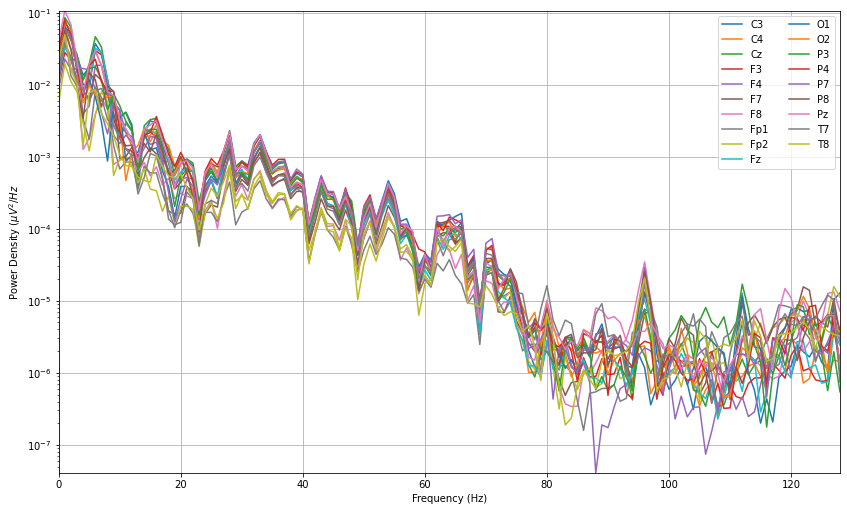

In [49]:
valid_data.plot_psd(recon[0])

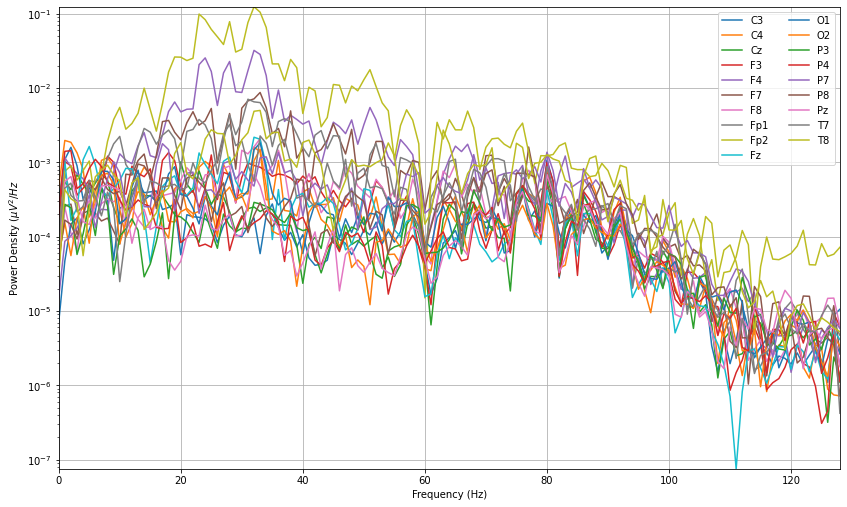

In [50]:
valid_data.plot_psd(first_segment - recon[0])

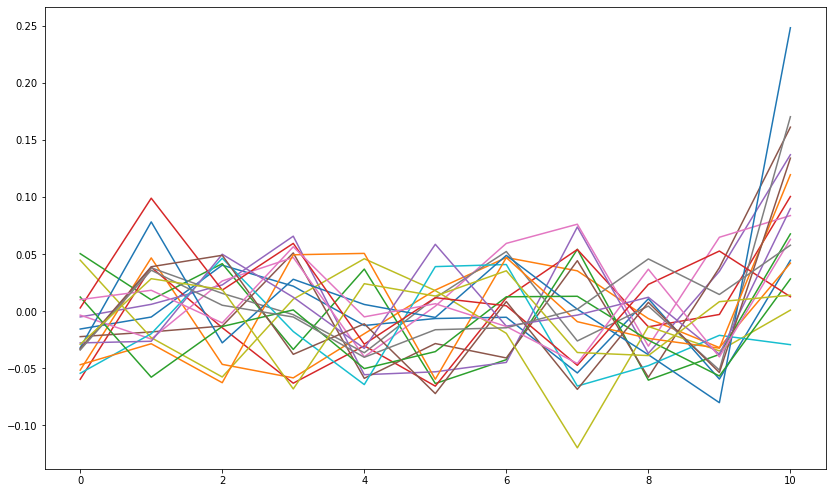

In [51]:
plt.plot(autoencoder.encoder.conv[0].conv.weight[0].detach().T);

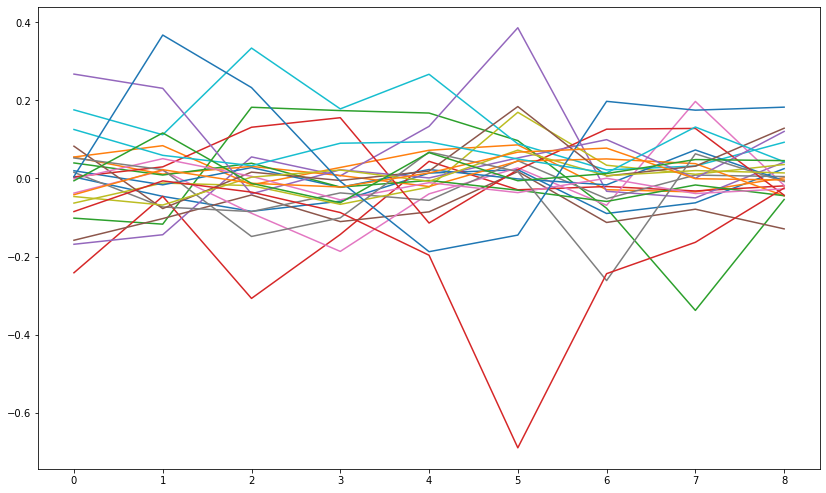

In [52]:
plt.plot(autoencoder.encoder.conv[1].conv.weight[0].detach().T);

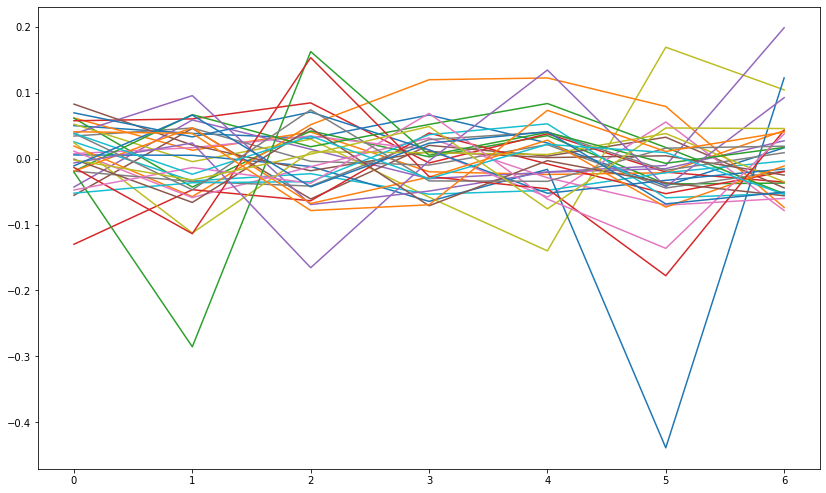

In [53]:
plt.plot(autoencoder.encoder.conv[2].conv.weight[0].detach().T);

## P300 Classification

In [54]:
class P3Dataset(EEGDataset):
    def __init__(self, subject, word, day=1, width=0.8, samp_rate=1024.0, autoencoder=None,
                 low_freq=0.5, high_freq=100.0, downsample_factor=4, clamp=60.0,
                 full_chan_names=chan_names_biosemi_32, select_chan_names=select_chan_names,
                 means=None, stdevs=None):
        orig_samp_rate = samp_rate
        new_samp_rate = samp_rate / downsample_factor
        del samp_rate
        
        data_mats = []
        
        bandpass_filter = self._make_bandpass(orig_samp_rate, low_freq, high_freq)
        notch_filter = self._make_notch(orig_samp_rate, 60.0)
        
        filenames = sorted(glob(f'data/p300grid/s{subject:02}-d{day}-*-{word}.pkl'))
        print(filenames)
        assert len(filenames) == 1
        filename = filenames[0]

        with open(filename, mode='rb') as fh:
            # FIXME: convert to py3 pickle
            raw_data = th.as_tensor(pickle.load(fh, encoding='bytes'), dtype=th.float32)
                
        raw_data, markers = raw_data[:, :-1], raw_data[:, -1]

        data = self._prep(
            data=raw_data,
            full_chan_names=full_chan_names,
            select_chan_names=select_chan_names,
            bandpass_filter=bandpass_filter,
            notch_filter=notch_filter,
            clamp=clamp,
            downsample_factor=downsample_factor)
        
        markers = markers[::downsample_factor]

        diffs = np.diff(np.abs(markers.numpy()))
        starts = np.where(diffs > 0.0)[0] + 1
    
        width_steps = int(width * new_samp_rate)
    
        data = th.stack([data[start:start+width_steps] for start in starts])
        
        self.labels = (markers[starts] > 0.0).type(th.int64)
            
        #data = np.ascontiguousarray(segments)
        
        assert len(select_chan_names) == data.shape[-1]
        nchan = data.shape[-1]

        self.means = data.reshape((-1, nchan)).mean(0) if means is None else means        
        assert self.means.shape == (nchan,)
        data -= self.means

        self.stdevs = data.reshape((-1, nchan)).std(0) if stdevs is None else stdevs
        assert self.stdevs.shape == (nchan,)
        data /= self.stdevs
        
        # we switch to shape (nseg, nchan, nobs) here since pytorch
        # convolution operators expect channel first
        data = data.permute(0, 2, 1)
        
        if autoencoder is not None:
            data = autoencoder.encode(data)

        super().__init__(data, new_samp_rate, select_chan_names)
        
    def __getitem__(self, idx):
        return self.data[idx], self.labels[idx]

In [55]:
p3_train_data = P3Dataset(
    subject=1, word='colorado',
    means=train_data.means, stdevs=train_data.stdevs,
    autoencoder=autoencoder)

['data/p300grid/s01-d1-p300grid-train-colorado.pkl']


In [56]:
p3_train_data[:10]

(tensor([[ 1.2761,  3.2872,  3.8582,  ..., -4.5459, -4.6114, -4.9648],
         [ 1.8314,  3.6358,  3.4345,  ..., -4.1457, -5.0480, -5.9346],
         [ 2.1586,  3.4201,  4.0658,  ..., -4.7186, -4.2923, -5.2723],
         ...,
         [ 1.7998,  3.2497,  3.9659,  ..., -4.3860, -3.9816, -4.9794],
         [ 1.6292,  4.1978,  3.9045,  ..., -4.6903, -5.2618, -6.0108],
         [ 2.2849,  3.8555,  3.5685,  ..., -3.7679, -3.8736, -4.8487]]),
 tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 1]))

In [57]:
p3_train_data[0][0].shape

torch.Size([624])

In [58]:
p3_train_data[0][0].min()

tensor(-10.1820)

In [59]:
p3_train_data[0][0].max()

tensor(12.1692)

In [60]:
#p3_train_data[0][0].mean(1)

In [61]:
#p3_train_data[0][0].std(1)

In [62]:
#plt.bar(p3_train_data[0][0]);

In [63]:
len(p3_train_data)

960

In [64]:
8*32*0.8

204.8

### 